# Building scenarios

Pymagicc offers the ability to join/merge scenarios to create custom scenarios. Here we show a minimal working example of how to do this.

In [1]:
from os.path import join

import pandas as pd

from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, join_timeseries
from pymagicc.definitions import (
    convert_magicc7_to_openscm_variables, 
    PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1
)

import expectexception

import matplotlib.pyplot as plt
plt.style.use('bmh') 
%matplotlib inline

In [2]:
DATA_DIR = join("..", "tests", "test_data")
DATA_MAGICC6_RUN = join("..", "pymagicc", "MAGICC6", "run")

To make the scenario, we have two options: read the files in then merge or merge from filepaths.

In [3]:
my_scen = join_timeseries(
    join(DATA_DIR, "RCP3PD_EMISSIONS.DAT"),
    join(DATA_MAGICC6_RUN, "RCP85.SCEN")
)

In [4]:
rcp = MAGICCData()
rcp.read(join(DATA_DIR, "RCP3PD_EMISSIONS.DAT"))
base = rcp.df

rcp.read(join(DATA_MAGICC6_RUN, "RCP85.SCEN"))
scen = rcp.df

preread_scen = join_timeseries(
    base,
    scen
)

In [5]:
# show they're the same
pd.testing.assert_frame_equal(my_scen, preread_scen)

The scen values overwrite the base values wherever they are provided. Also note that the output timeseries are inearly interpolated onto annual timesteps (unlike the input SCEN files which have irregular timesteps).

In [6]:
my_scen = join_timeseries(base, scen)
my_scen["time"].unique()

array([1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775,
       1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786,
       1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797,
       1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808,
       1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819,
       1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830,
       1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841,
       1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852,
       1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863,
       1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874,
       1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896,
       1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
       1908, 1909, 1910, 1911, 1912, 1913, 1914, 19

Note that only variable-region-unit combinations which are included in the base dataframe will be included in the resulting dataframe. Hence the output dataframe will not include the regional data from the scen file (we cannot yet automatically downscale).

In [7]:
my_scen[my_scen["region"] == "R5OECD"].empty

True

We can check the results as shown.

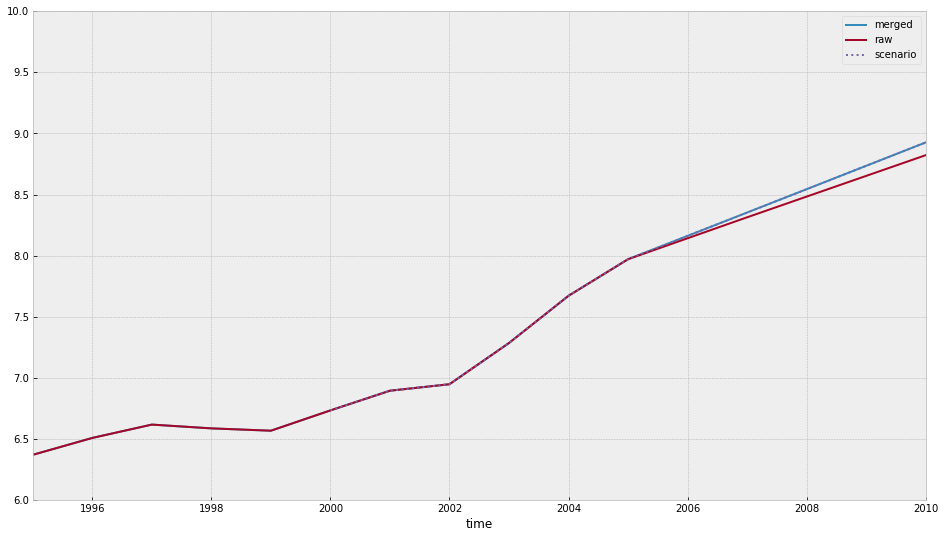

In [8]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

ax = my_scen[
    my_scen["variable"] == var_to_plot
].plot(x="time", y="value", label="merged", figsize=(16, 9))
base[
    (base["variable"] == var_to_plot)
    & (base["region"] == "World")
].plot(x="time", y="value", label="raw", ax=ax)
scen[
    (scen["variable"] == var_to_plot)
    & (scen["region"] == "World")
].plot(x="time", y="value", label="scenario", ls=":", ax=ax)
ax.set_xlim([1995, 2010])
ax.set_ylim([6, 10]);

If we put our scenario into a MAGICCData object and select only the variables which are used in SCEN files, we can then run it using Pymagicc.

In [9]:
magicc_scen = MAGICCData()
magicc_scen.df = my_scen.copy()

with MAGICC6() as magicc:
    results = magicc.run(magicc_scen)

/Users/zebedeenicholls/Documents/AGCEC/MCastle/pymagicc/pymagicc/io.py:1497: UserWarning: Ignoring input data which is not required for .SCEN file
  warnings.warn("Ignoring input data which is not required for .SCEN file")


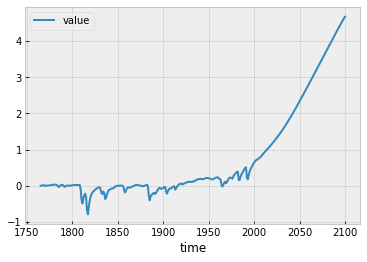

In [10]:
results.df[
    (results.df["variable"] == "Surface Temperature")
    & (results.df["region"] == "World")
].plot(x="time", y="value");

We can also join the timeseries with a linear join period. This allows us to use some base scenario, overwrite with a multitude of other scenarios but ensure they all have a common historical period and some roughly smooth transition. (At the moment the linear join period is the only option, a far more complete solution would be to use the [Aneris](https://github.com/iiasa/aneris) package but this would be a far more difficult step.)

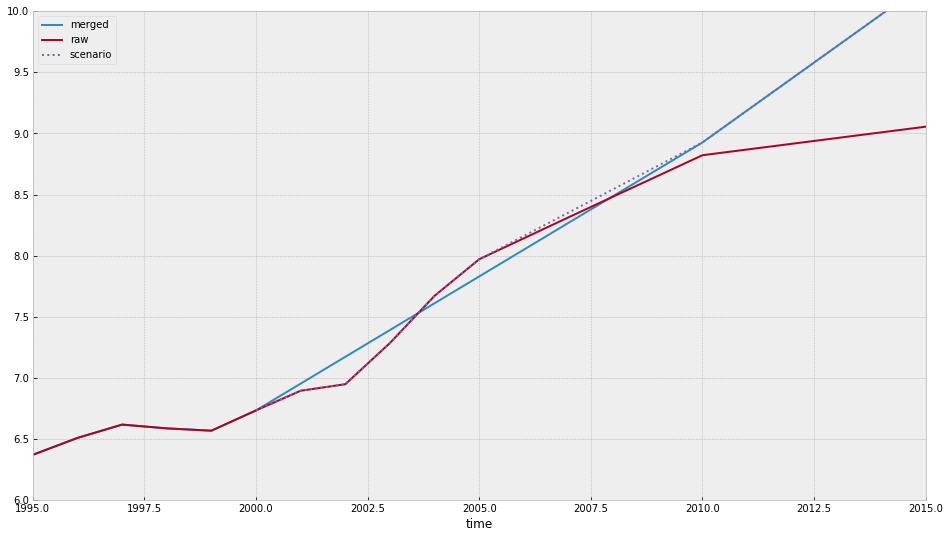

In [11]:
linear_scen = join_timeseries(base, scen, join_linear=[2000, 2010])
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

ax = linear_scen[
    linear_scen["variable"] == var_to_plot
].plot(x="time", y="value", label="merged", figsize=(16, 9))
base[
    (base["variable"] == var_to_plot)
    & (base["region"] == "World")
].plot(x="time", y="value", label="raw", ax=ax)
scen[
    (scen["variable"] == var_to_plot)
    & (scen["region"] == "World")
].plot(x="time", y="value", label="scenario", ls=":", ax=ax)
ax.set_xlim([1995, 2015])
ax.set_ylim([6, 10]);

In [12]:
magicc_scen = MAGICCData()
magicc_scen.df = linear_scen.copy()
for v in ["variable", "region", "todo", "unit"]:
    magicc_scen.df.loc[:, v] = magicc_scen.df[v].astype(str)
    
with MAGICC6() as magicc:
    results = magicc.run(magicc_scen)

/Users/zebedeenicholls/Documents/AGCEC/MCastle/pymagicc/pymagicc/io.py:1497: UserWarning: Ignoring input data which is not required for .SCEN file
  warnings.warn("Ignoring input data which is not required for .SCEN file")


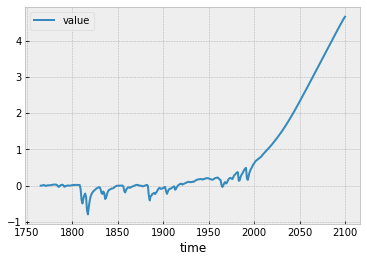

In [13]:
results.df[
    (results.df["variable"] == "Surface Temperature")
    & (results.df["region"] == "World")
].plot(x="time", y="value");

## Warning

If you try to merge data which has no overlapping indices, an error will be raised. For example, if we set our "todo" column to "N/A" in `base` (for an explanation of what this "todo" column is, see [file conventions](https://pymagicc.readthedocs.io/en/latest/file_conventions.html#columns)).

In [14]:
%%expect_exception ValueError

base["todo"] = "N/A"
join_timeseries(base, scen)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-14-6f8c1d13dceb> in <module>
      1 
      2 base["todo"] = "N/A"
----> 3 join_timeseries(base, scen)

~/Documents/AGCEC/MCastle/pymagicc/pymagicc/io.py in join_timeseries(base, overwrite, join_linear)
   2166         overwrite = reader.df
   2167 
-> 2168     result = _join_timeseries_mdata(base, overwrite, join_linear)
   2169 
   2170     return result

~/Documents/AGCEC/MCastle/pymagicc/pymagicc/io.py in _join_timeseries_mdata(base, overwrite, join_linear)
   2180 
   2181     if result.stack().index.intersection(ow.stack().index).empty:
-> 2182         raise ValueError("No overlapping indices, a simple append will do")
   2183 
   2184     result.update(ow, raise_conflict=False)

ValueError: No overlapping indices, a simple append will do
